<a href="https://colab.research.google.com/github/Tumars-web/E-commerce-user-growth-analysis/blob/main/notebooks/03_RFM%E7%94%A8%E6%88%B7%E5%88%86%E7%BE%A4%E5%88%86%E6%9E%90(RFM_segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import zipfile
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns


url = 'https://github.com/Tumars-web/E-commerce-user-growth-analysis/raw/main/cleaned_data.csv.zip'
zip_path = 'cleaned_data.zip'

# 下载压缩包
urllib.request.urlretrieve(url, zip_path)

# 解压缩
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# 读取 CSV
df = pd.read_csv('cleaned_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("数据加载成功！")
df.head()


数据加载成功！


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [33]:
#计算RFM指标

import datetime as dt

# 时间格式
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 🔧 添加总价列（防止报错）
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 创建 RFM 基准日（一般取最大时间 + 1天）
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# 计算每位用户的 RFM 三项指标
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # R：最后一次购买距离今天多久
    'InvoiceNo': 'nunique',                              # F：下单次数（订单号去重）
    'TotalPrice': 'sum'                                  # M：消费总额
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [34]:
# R 是越小越好，F 和 M 是越大越好
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4,3,2,1])  # R小得分高
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1,2,3,4])
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346,326,1,77183.60,1,1,4
1,12347,2,7,4310.00,4,4,4
2,12348,75,4,1797.24,2,3,4
3,12349,19,1,1757.55,3,1,4
4,12350,310,1,334.40,1,1,2


In [50]:
#生成 RFM 分数+标签
# 合并为一个 RFM 分数
rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

# 简单分群函数
def segment_user(score):
    if score >= 9:
        return '重要价值客户'
    elif score >= 7:
        return '高潜力客户'
    elif score >= 5:
        return '一般保持客户'
    else:
        return '流失风险客户'

# 应用分群
rfm['Segment'] = rfm['RFM_Score'].apply(segment_user)

# 替换为英文标签
rfm['Segment'] = rfm['Segment'].replace({
    '重要价值客户': 'Important Value',
    '高潜力客户': 'High Potential',
    '一般保持客户': 'General Retention',
    '流失风险客户': 'Churn Risk'
})

# 查看分布
print(rfm['Segment'].value_counts())


Segment
Important Value      1679
General Retention     988
High Potential        864
Churn Risk            807
Name: count, dtype: int64


/tmp/ipython-input-51-3417206378.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


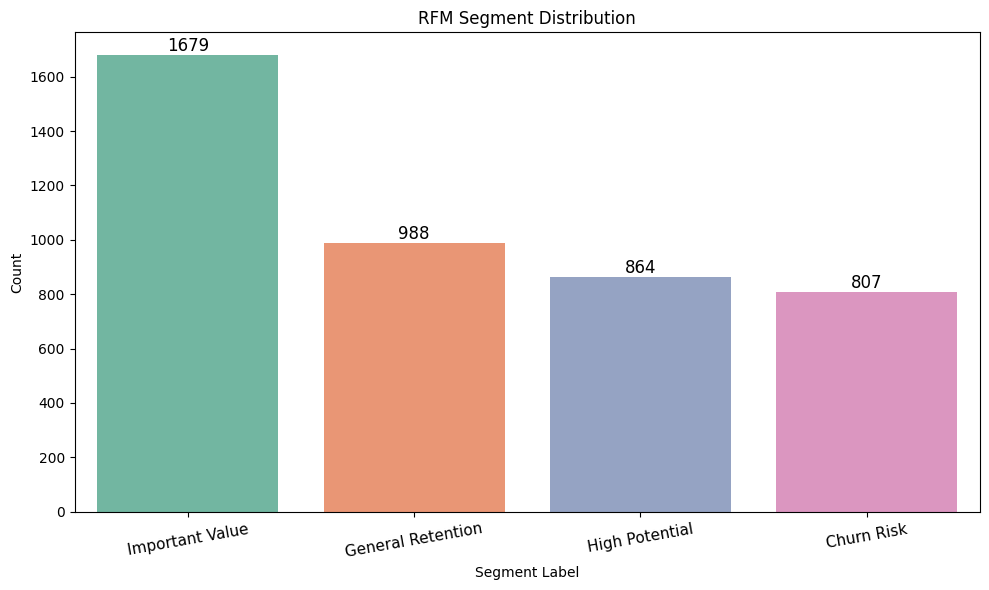

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# 可视化
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=rfm,
    x='Segment',
    order=rfm['Segment'].value_counts().index,
    palette='Set2'
)

# 每个柱子上加上数字
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.title('RFM Segment Distribution')
plt.xlabel('Segment Label')
plt.ylabel('Count')
plt.xticks(rotation=10, fontsize=11)
plt.tight_layout()
plt.show()
